In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

## Read & Show images  

In [2]:
frame1=cv2.imread("../input/mall-dataset/seq_000001.jpg",0)
frame2=cv2.imread("../input/mall-dataset/seq_000002.jpg")
frame2=cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

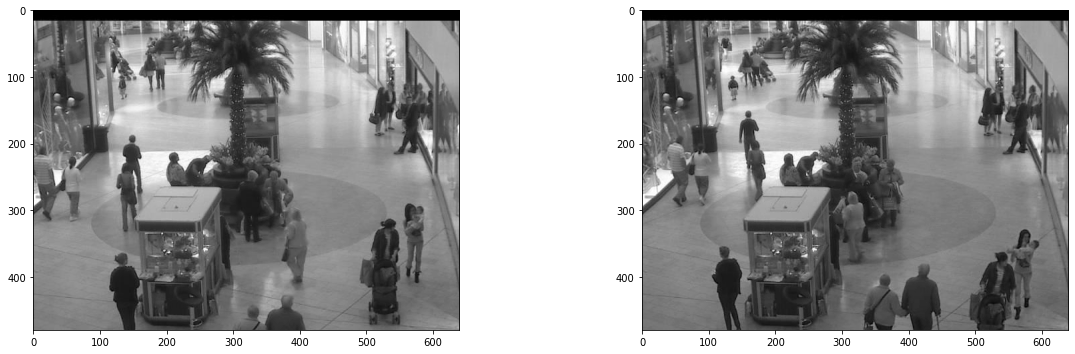

In [3]:
f=plt.figure(figsize=(20,20))
f.add_subplot(3,2,1)
plt.imshow(frame1,cmap='gray')
f.add_subplot(3,2,2)
plt.imshow(frame2,cmap='gray')

## Robot & Laplacian of Gaussian Mask for Image Derivatives

In [4]:
mask_x=np.array([[-1,1],[-1,1]])
mask_y=np.array([[-1,-1],[1,1]])
mask_t1=np.array([[-1,-1],[-1,-1]])
mask_t2=np.array([[1,1],[1,1]])
mask_lap=np.array([[1/12,1/6,1/12],[1/6,0,1/6],[1/12,1/6,1/12]])
print(mask_lap)

[[0.08333333 0.16666667 0.08333333]
 [0.16666667 0.         0.16666667]
 [0.08333333 0.16666667 0.08333333]]


## After Remove noise using  GaussianBlur

In [5]:
frame1=cv2.GaussianBlur(frame1,(5,5),0)
frame2=cv2.GaussianBlur(frame2,(5,5),0)

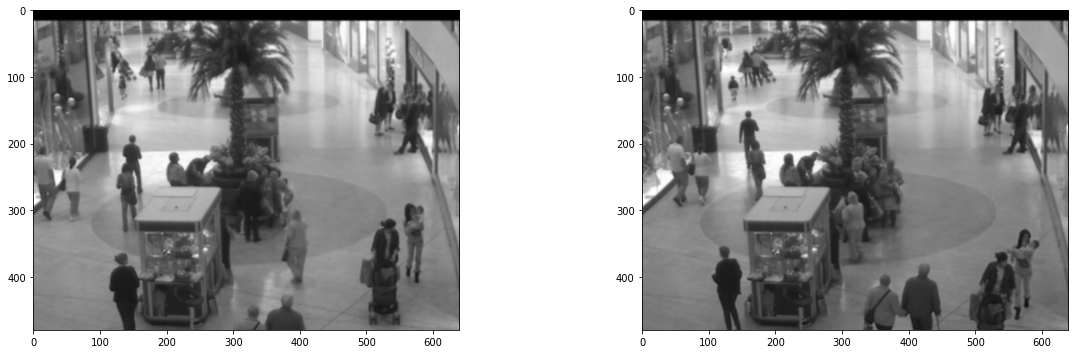

In [6]:
f=plt.figure(figsize=(20,20))
f.add_subplot(3,2,1)
plt.imshow(frame1,cmap='gray')
f.add_subplot(3,2,2)
plt.imshow(frame2,cmap='gray')

## Calculate Image Derivatives 

In [7]:
fx=signal.convolve2d(frame1,mask_x,mode='same')+signal.convolve2d(frame2,mask_x,mode='same')
fy=signal.convolve2d(frame1,mask_y,mode='same')+signal.convolve2d(frame2,mask_y,mode='same')
ft=signal.convolve2d(frame1,mask_t1,mode='same')+signal.convolve2d(frame2,mask_t2,mode='same')

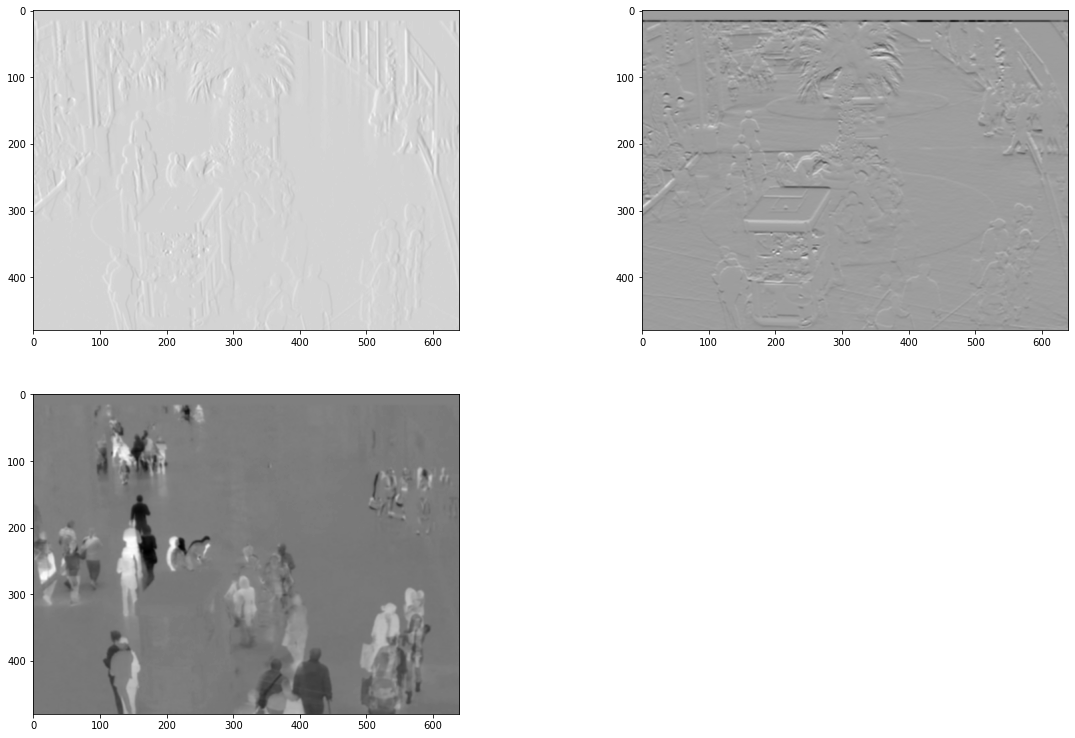

In [8]:
f=plt.figure(figsize=(20,20))
f.add_subplot(3,2,1)
plt.imshow(fx,cmap='gray')
f.add_subplot(3,2,2)
plt.imshow(fy,cmap='gray')
f.add_subplot(3,2,3)
plt.imshow(ft,cmap='gray')

## Initialize  U & V with zero values 

In [9]:
u=np.zeros(frame1.shape)
v=np.zeros(frame1.shape)

## Calculate U , V using Lucas Kanade Algorithm 

In [10]:
for i in range(1,u.shape[0]):
    for j in range(1,u.shape[1]):
        fxx=fx[i-1:i+2,j-1:j+2].flatten()
        fyy=fy[i-1:i+2,j-1:j+2].flatten()
        ftt=ft[i-1:i+2,j-1:j+2].flatten()
        A=np.vstack([fxx,fyy]).T
        res = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), ftt)
        u[i,j]=res[0]
        v[i,j]=res[1]
uc=u
vc=v

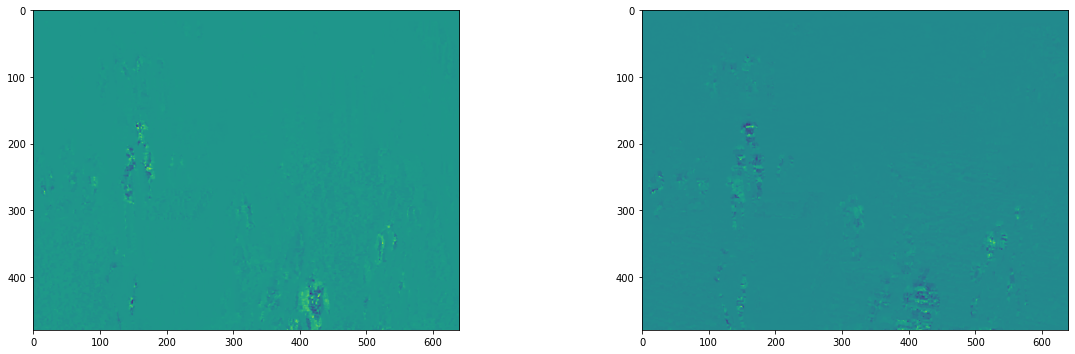

In [11]:
f=plt.figure(figsize=(20,20))
f.add_subplot(3,2,1)
plt.imshow(u)
f.add_subplot(3,2,2)
plt.imshow(v)

## Draw plots 

In [12]:
def draw_flow(im,flow,step):
    h,w = im.shape
    y,x = np.mgrid[step:h:step,step:w:step].reshape(2,-1)
    fx,fy = flow[y,x].T
 
    # create line endpoints
    lines = np.vstack([x,y,x+fx,y+fy]).T.reshape(-1,2,2)
    lines = np.int32(lines)
 
    # create image and draw
    vis = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
    for (x1,y1),(x2,y2) in lines:
        cv2.line(vis,(x1,y1),(x2,y2),(255,0,0),1)
        cv2.circle(vis,(x1,y1),1,(0,255,0), -1)
    return vis

In [13]:
mergeruv1=np.concatenate((uc,vc),axis=1).reshape((480, 640,2))

In [14]:
drwimg1=draw_flow(frame2,mergeruv1,8)

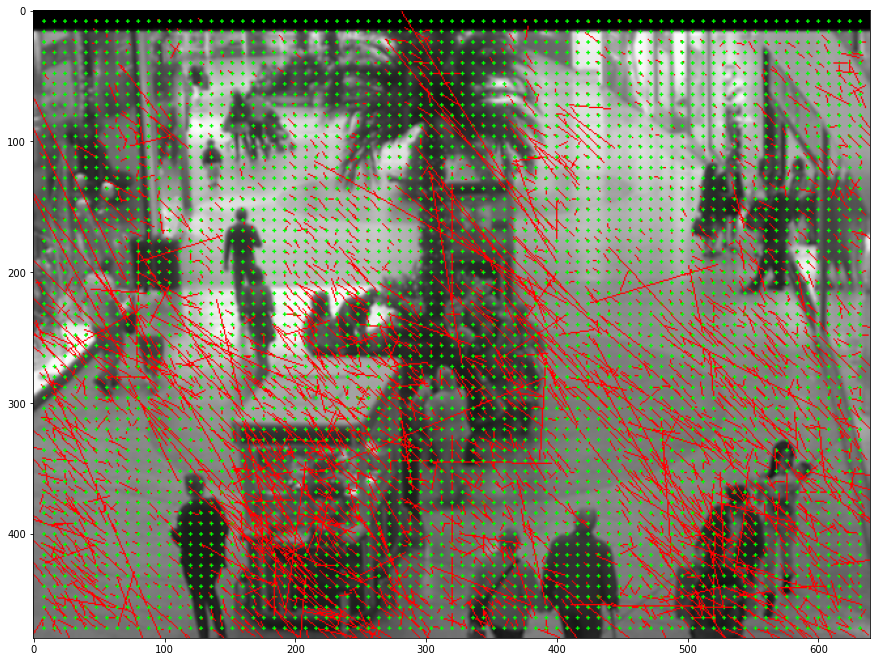

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(drwimg1)

In [16]:
# try least squares fit instead, we expect it is less error, smoother field
for i in range(1, u.shape[0]):
    for j in range(1, u.shape[1]):
        u_num = - np.sum(np.power(fy[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], ft[i - 1:i + 2, j - 1:j + 2])) + \
        np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], fy[i - 1:i + 2, j - 1:j + 2])) * \
        np.sum(np.multiply(fy[i - 1:i + 2, j - 1:j + 2], ft[i - 1:i + 2, j - 1:j + 2]))
        u_denom = np.sum(np.power(fx[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.power(fy[i - 1:i + 2, j - 1:j + 2], 2)) - \
        np.power(np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], fy[i - 1:i + 2, j - 1:j + 2])), 2)
        
        v_num = np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], ft[i - 1:i + 2, j - 1:j + 2])) * \
        np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], fy[i - 1:i + 2, j - 1:j + 2])) - \
        np.sum(np.power(fx[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.multiply(fy[i - 1:i + 2, j - 1:j + 2], ft[i - 1:i + 2, j - 1:j + 2]))
        v_denom = np.sum(np.power(fx[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.power(fy[i - 1:i + 2, j - 1:j + 2], 2)) - \
        np.power(np.sum(np.multiply(fx[i - 1:i + 2, j - 1:j + 2], fy[i - 1:i + 2, j - 1:j + 2])), 2)
        
        u[i, j] = u_num / u_denom
        v[i, j] = v_num / v_denom

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


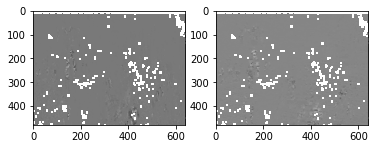

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(u, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(v, cmap = 'gray')

In [18]:
n, m = u.shape
u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
[X,Y] = np.meshgrid(np.arange(m, dtype = 'float64'), np.arange(n, dtype = 'float64'))
X_deci = X[np.ix_(range(0, n, 5), range(0, m, 5))]
Y_deci = Y[np.ix_(range(0, n, 5), range(0, m, 5))]

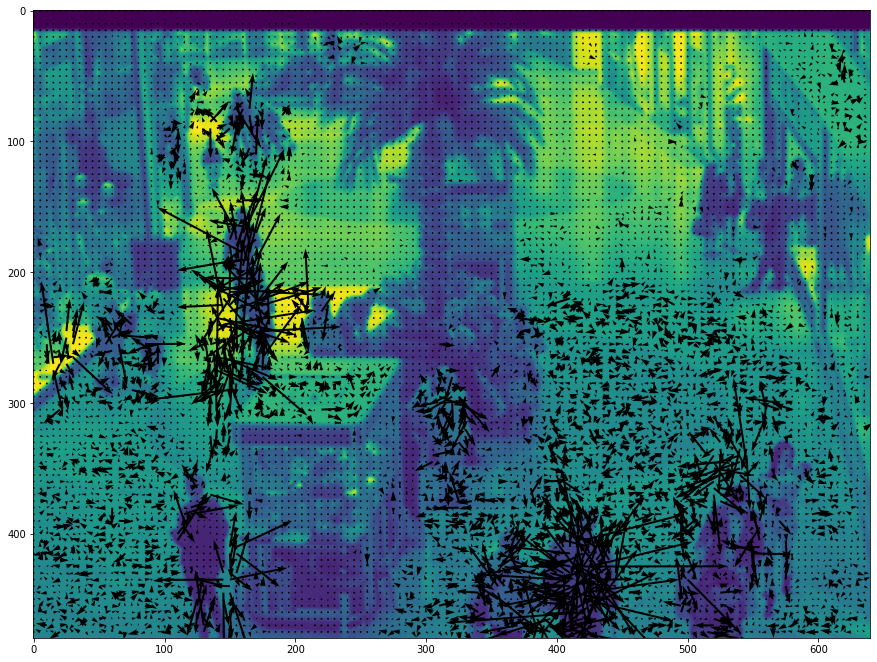

In [19]:
u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
plt.figure(figsize=(15,15))
plt.imshow(frame2)
plt.quiver(X_deci, Y_deci, u_deci, v_deci)

## Calculate U , V using  Horn Schunck Method

In [20]:
uh=np.zeros(frame1.shape)
vh=np.zeros(frame1.shape)
for i in range(100):
    uavg=signal.convolve2d(uh,mask_lap,mode='same')
    vavg=signal.convolve2d(vh,mask_lap,mode='same')
    num=fx*uavg+fy*vavg+ft
    den=4*15+fx**2+fy**2
    uh=uavg-fx*(num/den)
    vh=vavg-fy*(num/den)

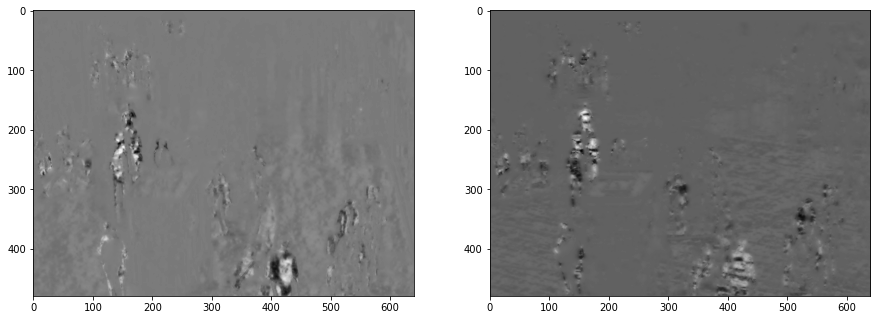

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(uh, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(vh, cmap = 'gray')

In [22]:
mergeruv2=np.concatenate((uh,vh),axis=1).reshape((480, 640,2))

In [23]:
drwimg2=draw_flow(frame2,mergeruv2,8)

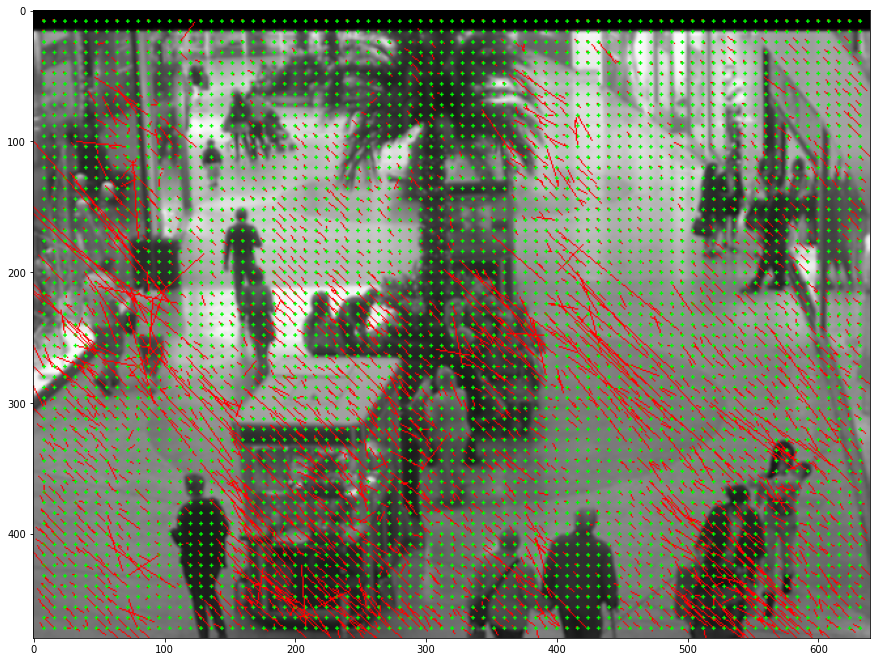

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(drwimg2)

## Final output for Lucas kanade & Horn schunck Methods 

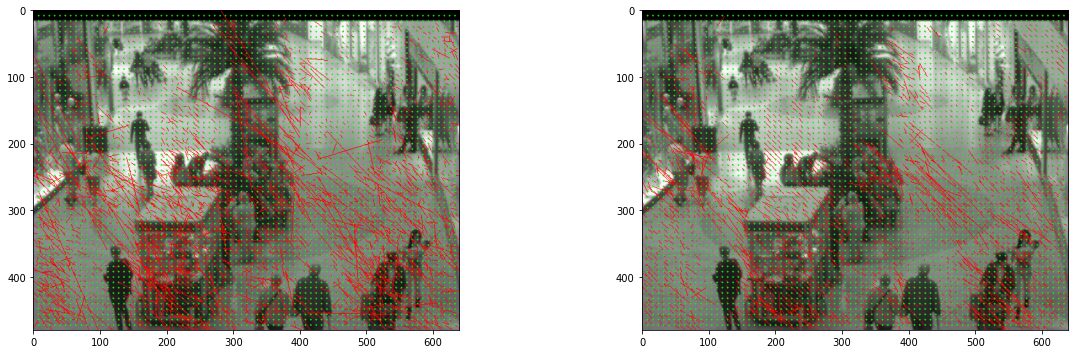

In [25]:
f=plt.figure(figsize=(20,20))
f.add_subplot(3,2,1)
plt.imshow(drwimg1)
f.add_subplot(3,2,2)
plt.imshow(drwimg2)